# VARIABILITY INVESTIGATION

In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
import intake, intake_esm
import os
import sys
from pathlib import Path
from glob import glob
import itertools
import time
import seaborn as sns
import math
import scipy.stats as st
import requests
import pywt

import warnings
warnings.filterwarnings('ignore')

%run functions.ipynb

In [2]:
'''
Les fichiers sont stockés dans deux catalogues :
    - PMIPCat.json : Modèles Paleo
    - CMIPCat.json : Modèles Actuel (avec piControl notamment)
'''

PMIP = intake.open_esm_datastore("PMIPCat.json")
CMIP = intake.open_esm_datastore('CMIPCat.json')

In [4]:
'''
Coordonnées du site EPICA Dome C
'''

lat_edc = -75.06
lon_edc = 123.2

# Création des données de variance de TAS

### PMIP3 datas

In [41]:
dir_pmip3, pmip3 = PMIP3_dic()
var_def = var_dic()
period = {
    'ds_pi':'piControl',
    'ds_lgm': 'lgm'
    }
grid = ['gn', 'gr1', 'gr']
res_lat = 1.25
res_lon = 1.875

var = 'tas'

df_pmip3 = pd.DataFrame(columns = ['institute', 'source', 'period', 'type', 'variance'])


for model in pmip3:
    file_dir, filename = read_model(
        model, 
        'lgm',
        var_def, 
        var, 
        dir_pmip3
        )
    if os.path.exists(file_dir) :
        for k, v in period.items() :
            file_dir, filename = read_model(
                model, 
                v,
                var_def, 
                var, 
                dir_pmip3
                ) 
            
            ds = xr.open_mfdataset(filename)[var]
            ds = zonal_reduction(ds, lon_edc, lat_edc , 5, 2.5)
            ds = ds.mean(['lat', 'lon'])
            ds = ds.var('time')       

            data = pd.DataFrame()
            data['institute'] = [pmip3[model]['institute']]
            data['source'] = [model]
            data['period'] = [v]
            data['type'] = ['pmip3']
            data['variance'] = float(ds.values)
            df_pmip3 = df_pmip3.append(data)

Reading tas CNRM-CM5 for lgm
Reading tas CNRM-CM5 for piControl
Reading tas CNRM-CM5 for lgm
Reading tas COSMOS-ASO for lgm
Reading tas COSMOS-ASO for piControl
Reading tas COSMOS-ASO for lgm
Reading tas IPSL-CM5A-LR for lgm
Reading tas IPSL-CM5A-LR for piControl
Reading tas IPSL-CM5A-LR for lgm
Reading tas FGOALS-g2 for lgm
Reading tas FGOALS-g2 for piControl
Reading tas FGOALS-g2 for lgm
Reading tas MIROC-ESM for lgm
Reading tas MIROC-ESM for piControl
Reading tas MIROC-ESM for lgm
Reading tas MPI-ESM-P for lgm
Reading tas MPI-ESM-P for piControl
Reading tas MPI-ESM-P for lgm
Reading tas MRI-CGCM3 for lgm
Reading tas MRI-CGCM3 for piControl
Reading tas MRI-CGCM3 for lgm
Reading tas GISS-E2-R for lgm
Reading tas GISS-E2-R for piControl
Reading tas GISS-E2-R for lgm
Reading tas CCSM4 for lgm
Reading tas CCSM4 for piControl
Reading tas CCSM4 for lgm


In [8]:
''' 
L'objectif est de comparer la variance d'une variable entre périodes.

Plusieurs étapes :
    - spécification des variables
    - création d'un dataframe vide qui va être rempli
    - import des données via le catalogue pour le piControl et pour les autres périodes. 
      Si le chemin existe pour chaque variables alors le fichier est téléchargé. 
      Durant l'import, les données sont :
            . aggrégées avec dask
            . réduite à la zone autours d'EPICA Dome C
            . moyennées dans l'espace
            . On récupère la variance dans la temps
            
    - enregistrement dans le dataframe : df
'''


var = 'tas'
inst = PMIP.df['institution_id'].unique()
source = PMIP.df['source_id'].unique()
date = ['lgm', 'lig127k', 'piControl']
grid = ['gn', 'gr1', 'gr']

df = pd.DataFrame(columns = ['variance', 'institute', 'source', 'period', 'type'])

for i in inst :
    for s in source :
        for g in grid :
            if os.path.exists('/bdd/CMIP6/CMIP/{}/{}/piControl/r1i1p1f1/Amon/{}/{}/latest'.format(i, s, var, g)) :
                X = CMIP.search(
                    institution_id= '{}'.format(i), 
                    variable_id = var,
                    source_id = '{}'.format(s),
                    table_id = 'Amon', 
                    experiment_id= 'piControl',  
                    latest = True,  
                    member_id = "r1i1p1f1",
                    grid_label = '{}'.format(g)
                    )
                institute_ds = xr.open_mfdataset(
                    list(X.df["path"]),
                    chunks = 500,
                    use_cftime=True,
                    decode_cf=True
                    )
                ds = institute_ds.where((
                    (institute_ds.coords["lat"] > lat_edc - 2.5 )
                        & (institute_ds.coords['lat'] < lat_edc + 2.5) 
                        & (institute_ds.coords['lon'] > lon_edc - 5) 
                        & (institute_ds.coords['lon'] < lon_edc + 5)),
                    drop=True
                    ) 
                ds = ds.mean(['lat', 'lon'])
                ds = ds.var('time')
                print('Computing {} for : {} - {} :'.format(d, s, var))
                with ProgressBar():
                    ds = ds.compute()
                
                data = pd.DataFrame()
                data['variance'] = list([np.float(ds[var])])
                data['institute'] = i
                data['source'] = s
                data['period'] = 'piControl'
                data['grid'] = g
                df = df.append(data)

                
            for d in date :
                if os.path.exists('/bdd/CMIP6/PMIP/{}/{}/{}/r1i1p1f1/Amon/{}/{}/latest'.format(i, s, d, var, g)) :
                    X = PMIP.search(
                        institution_id= '{}'.format(i), 
                        variable_id = var, 
                        source_id = '{}'.format(s),
                        table_id = 'Amon', 
                        experiment_id= '{}'.format(d),
                        latest = True,
                        member_id = "r1i1p1f1",
                        grid_label = '{}'.format(g)
                        )
                    institute_ds = xr.open_mfdataset(
                        list(X.df["path"]),
                        chunks = 500,
                        use_cftime=True,
                        decode_cf=True
                        )
                    ds = institute_ds.where((
                        (institute_ds.coords["lat"] > lat_edc - 5 ) 
                            & (institute_ds.coords['lat'] < lat_edc + 5) 
                            & (institute_ds.coords['lon'] > lon_edc - 15) 
                            & (institute_ds.coords['lon'] < lon_edc + 15)),
                        drop=True
                        ) 
                    ds = ds.mean(['lat', 'lon'])
                    ds = ds.var('time')
                    print('Computing {} for : {} - {} :'.format(d, s, var))
                    with ProgressBar():
                        ds = ds.compute()

                    data = pd.DataFrame()
                    data['variance'] = list([np.float(ds[var])])
                    data['institute'] = i
                    data['source'] = s
                    data['period'] = d
                    data['type'] = ['pmip4']
                    df = df.append(data)                    

Computing piControl for : IPSL-CM6A-LR - tas :
[########################################] | 100% Completed | 21.9s
Computing lig127k for : IPSL-CM6A-LR - tas :
[########################################] | 100% Completed |  6.2s
Computing lig127k for : HadGEM3-GC31-LL - tas :
[########################################] | 100% Completed |  3.1s
Computing piControl for : ACCESS-ESM1-5 - tas :
[########################################] | 100% Completed | 21.2s
Computing lig127k for : ACCESS-ESM1-5 - tas :
[########################################] | 100% Completed |  4.5s
Computing piControl for : FGOALS-f3-L - tas :
[########################################] | 100% Completed | 14.7s
Computing lig127k for : FGOALS-f3-L - tas :
[########################################] | 100% Completed | 12.9s
Computing piControl for : FGOALS-g3 - tas :
[########################################] | 100% Completed |  6.9s
Computing lig127k for : FGOALS-g3 - tas :
[########################################] | 1

In [43]:
df2 = df.append(df_pmip3)

### Figure de la distribution de la variance du TAS autours d'EPICA Dome C

Text(0.5, 1.0, 'Temperature of Air Surface Variance around EPICA Dome C')

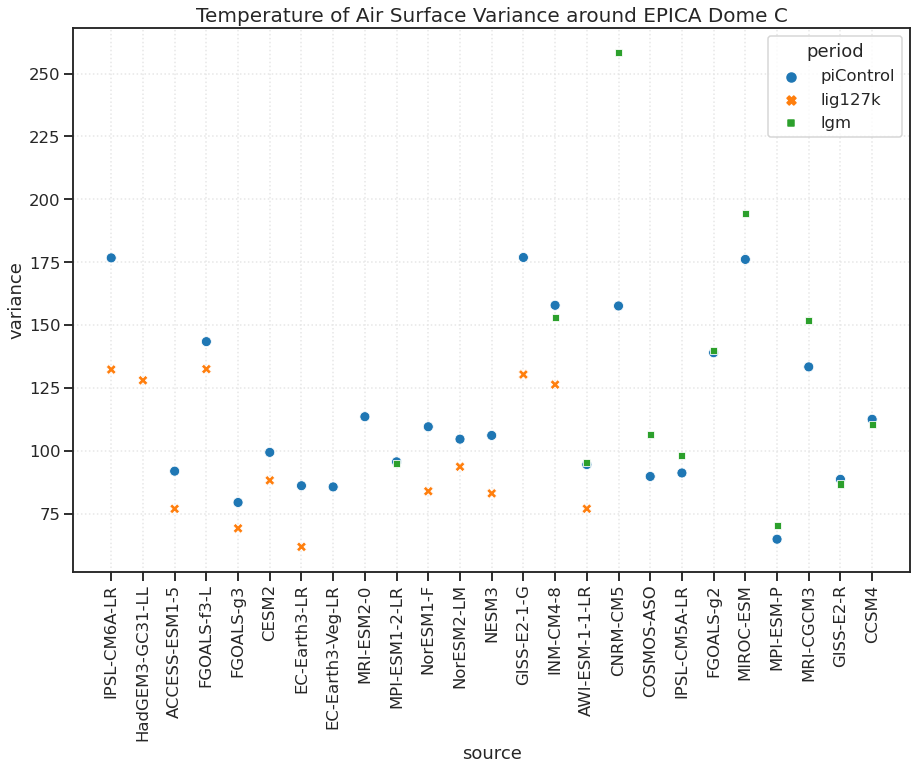

In [45]:
'''
On souhaite construire une figure observant la distribution de
la variance du TAS dans le dataframe : df.
On les compares selon les modèles (x abscisse) et entre périodes (couleurs)

Les étapes :
    - Construction du style de la figure
    - Plot des nuages de points des données : df
    - Enregistrement de l'image
'''

sns.set_context("talk")
sns.set_style('ticks')
sns.set_context("talk") 
sns.set_style(
    'ticks', 
    {"grid.color":"0.9", 
     "grid.linestyle":":", 
     "axes.grid": True
    })
plt.figure(figsize = (15,10))

sns.scatterplot(
    data = df2, 
    x = 'source', y = 'variance', 
    hue = 'period', 
    style = 'period', 
    s = 100
    )

plt.xticks(rotation=90)
#Echelle logarithmique
#plt.yscale('log')

plt.title('Temperature of Air Surface Variance around EPICA Dome C', fontsize = 20)
# plt.savefig('/home/bchaigneau/Stage_LSCE/plot/variability/TAS_var.jpeg',dpi= 100)

### Regarder la RH weighted dans l'Indien

### Pour observer la zone d'étude

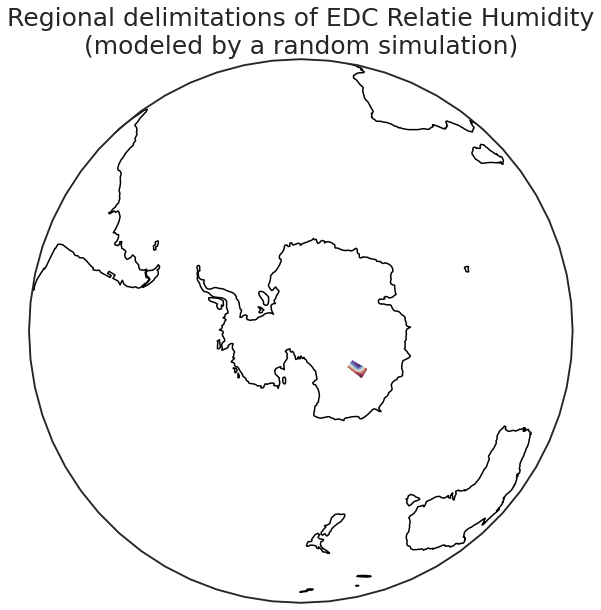

In [20]:
'''
Ce script sert à observer la zone d'étude qui a été établie.

Les étapes :
    - on pren un dataset aléatoire du précédent script
    - on sélectionne la zone d'étude
    - Définition de la projection en Orthographic
    - On plot
    - On enregistre la figure
'''


ds_plt = institute_ds.where((
    (institute_ds.coords["lat"] > lat_edc - 2.5 ) 
        & (institute_ds.coords['lat'] < lat_edc + 2.5) 
        & (institute_ds.coords['lon'] > lon_edc - 5) 
        & (institute_ds.coords['lon'] < lon_edc + 5)),
    drop=True
    )
ds_plt = ds_plt.mean('time')

plt.figure(figsize = (15,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude = -90, 
                                           central_longitude = 0))

plt.contourf(
    ds_plt.lon, ds_plt.lat, ds_plt.tas, 
    60,
    transform=ccrs.PlateCarree(), 
    cmap = 'twilight_shifted', 
    alpha = 0.4
)
ax.coastlines()
ax.set_global()

plt.title('Regional delimitations of EDC Relatie Humidity\n(modeled by a random simulation)', size = 25)
# plt.savefig('/home/bchaigneau/Stage_LSCE/plot/tas/map_regions.jpeg', dpi= 100)
plt.show()